# Entender o Problema

- Objetivo do Problema:
    - Predição de qual país será o primeiro destino de reserva de um novo usuário;
    - Porque?
        - Qual o tipo de modelo de negócio do Airbnb?
            - Marketplace (conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação)
            - Oferta (pessoas oferecendo acomodação)
                - Tamanho do portifólio
                - Diversisdade/Densidade de Portfólio
                - preço Médio
            - Demanda (pessoas procurando acomodação)
                - Número de Usuários
                - LTV (Lifetime Value)
                - CAC ( Client Acquisition Cost)

        Gross Revenue = (Fee*Numero cliente) - CAC

- Proposta de Solução:
    - Modelo de Previsão do primeiro destino de um novo usuário
    - 1.0. Predições salvas em uma tabela do banco de dados
    - 2.0. API
        - Input: usuário e suas características
        - Output: usuário e suas características com a predição de destino

# <font color='red'>Ciclo 01: End to End</font>

# 0.0. Imports

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt

from keras import models as ml
from keras.layers import Dense, Dropout

import tensorflow as tf
tf.get_logger().setLevel('INFO')


## 0.1. Helper Functions

## 0.2. Loading Data

In [3]:
df_users_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)

df_sessions_raw = pd.read_csv('../data/sessions.csv', low_memory=True)

df_users_raw.shape

(213451, 16)

# 1.0 Data Description

In [4]:
df1 = df_users_raw.copy()

## 1.1. Data Dimension

In [5]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of rows 213451
Number of columns 16


## 1.2. Data Types

In [6]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [7]:
df1.head().T

,0,1,2,3,4
id,gxn3p5htnn,820tgsjxq7,4ft3gnwmtx,bjjt8pjhuk,87mebub9p4
date_account_created,2010-06-28,2011-05-25,2010-09-28,2011-12-05,2010-09-14
timestamp_first_active,20090319043255,20090523174809,20090609231247,20091031060129,20091208061105
date_first_booking,NaN,NaN,2010-08-02,2012-09-08,2010-02-18
gender,-unknown-,MALE,FEMALE,FEMALE,-unknown-
age,NaN,38.0,56.0,42.0,41.0
signup_method,facebook,facebook,basic,facebook,basic
signup_flow,0,0,3,0,0
language,en,en,en,en,en
affiliate_channel,direct,seo,direct,direct,direct


## 1.3. Check NAs

In [8]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [9]:
# remiove missing values
df1 = df1.dropna()
df1.shape

(68171, 16)

## 1.4. Change Types

In [10]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'], format='%Y-%m-%d')

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'], format='%Y-%m-%d')

# age
df1['age'] = df1['age'].astype(int)

In [11]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.5 Check Balanced Data

In [12]:
# response variable is the columns country_destination
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0. Feature Engineering

In [13]:
df2 = df1.copy()

# 3.0. Feature Filtering

## 3.1. Filtering Rows

## 3.2 Columns Selection

# 4.0. Exploratory Data Analysis

# 5.0. Data Preparation

In [14]:
df5 = df2.copy()

In [15]:
# dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id', 'country_destination'], axis=1))

# join id and country destination
df5 = pd.concat([df5[['id', 'country_destination']], df5_dummy], axis=1)

# 6.0 Feature Selection

In [16]:
df6 = df5.copy()
cols_drop = ['id', 'date_account_created', 'timestamp_first_active', 'date_first_booking'] #original dates

df6 = df6.drop(cols_drop, axis=1)

# 7.0. Machine Learning Model

In [17]:
X = df6.drop('country_destination', axis=1)
y = df6[['country_destination']]

In [18]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

### Viés de Seleção: 

- Utilizando train_test_split posso "dar sorte" de selecionar uma boa amostra do meu conjunto de dados para treino e uma pessima amostra do conjunto de dados para teste

- Alguns comportamentos podem esar escondidos em amostras não selecionadas

- O comportamento dos dados de treino podem estar diferentes dos dados de teste


### Solução: 
- Amostrar o conjunto de dados mais vezes, para aumentar a chance do modelo aprender todos os padrões dos dados

### **Cross-Validation**

- K-Fold (5 a 10 folds)
- leave_one-Out -> super custoso mas garante que todos os possiveis padrões dos dados sejam vistos pelo modelo
- Não Funciona muito bem para séries temporais
- Não Funciona muito bem com dados desbalanceados

## 7.1.1. Baseline Model

In [19]:
country_destination_list = df6['country_destination'].drop_duplicates().sort_values().tolist()
country_destination_weights = df6['country_destination'].value_counts(normalize=True).sort_index().tolist()

# modelo que chuta de forma aleatória
yhat_random = random.choices(population=country_destination_list, 
                             k=len(y_test), 
                             weights= country_destination_weights)

Accuracy: 0.5177851118445178
Balanced Accuracy: 0.09124728874053778
Kappa Score: 0.000850240153362325
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.03      0.03      0.03       170
          ES       0.02      0.01      0.01       345
          FR       0.05      0.06      0.06       710
          GB       0.03      0.03      0.03       344
          IT       0.03      0.03      0.03       423
          NL       0.02      0.02      0.02       128
          PT       0.00      0.00      0.00        36
          US       0.70      0.71      0.71      9624
       other       0.12      0.12      0.12      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

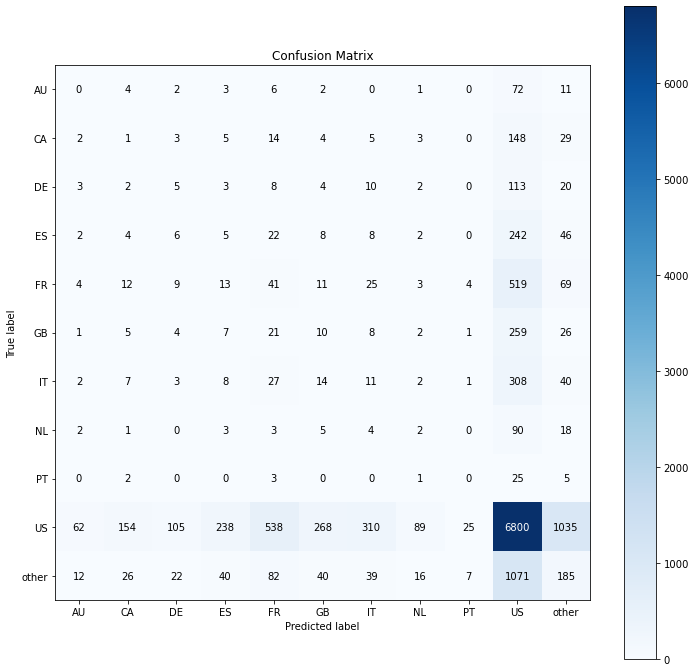

In [20]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random, zero_division=0))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12))

## 7.1.2. Neral Network - MLP

In [21]:
# Categorically encode labels
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [26]:
# moel definition
model = ml.Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(11, activation='softmax'))

# model compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train model
model.fit(X_train, y_train_nn, epochs=50, verbose=1)

Epoch 1/50
54536/54536 [==============================] - 3s 46us/step - loss: 1.4125 - accuracy: 0.6998
Epoch 2/50
54536/54536 [==============================] - 2s 43us/step - loss: 1.2805 - accuracy: 0.7081
Epoch 3/50
54536/54536 [==============================] - 2s 43us/step - loss: 1.2316 - accuracy: 0.7080
Epoch 4/50
54536/54536 [==============================] - 2s 44us/step - loss: 1.1940 - accuracy: 0.7084
Epoch 5/50
54536/54536 [==============================] - 2s 44us/step - loss: 1.1691 - accuracy: 0.7086
Epoch 6/50
54536/54536 [==============================] - 3s 46us/step - loss: 1.1518 - accuracy: 0.7089
Epoch 7/50
54536/54536 [==============================] - 2s 44us/step - loss: 1.1442 - accuracy: 0.7088
Epoch 8/50
54536/54536 [==============================] - 2s 43us/step - loss: 1.1366 - accuracy: 0.7094
Epoch 9/50
54536/54536 [==============================] - 2s 45us/step - loss: 1.1343 - accuracy: 0.7095
Epoch 10/50
54536/54536 [==============================

In [27]:
# prediction
pred_nn = model.predict(X_test)

# invert prediction
yhat_nn = np.ravel(ohe.inverse_transform(pred_nn))

# prediction prepare
y_test_nn = np.ravel(y_test.to_numpy())

In [35]:
ohe.inverse_transform(pred_nn)

(13635, 1)

Accuracy: 0.7037037037037037
Balanced Accuracy: 0.09169517236980386
Kappa Score: 0.0014100346858162416
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.50      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.25      0.00      0.01       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.16      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.15      0.09      0.08     13635
weighted avg       0.54      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

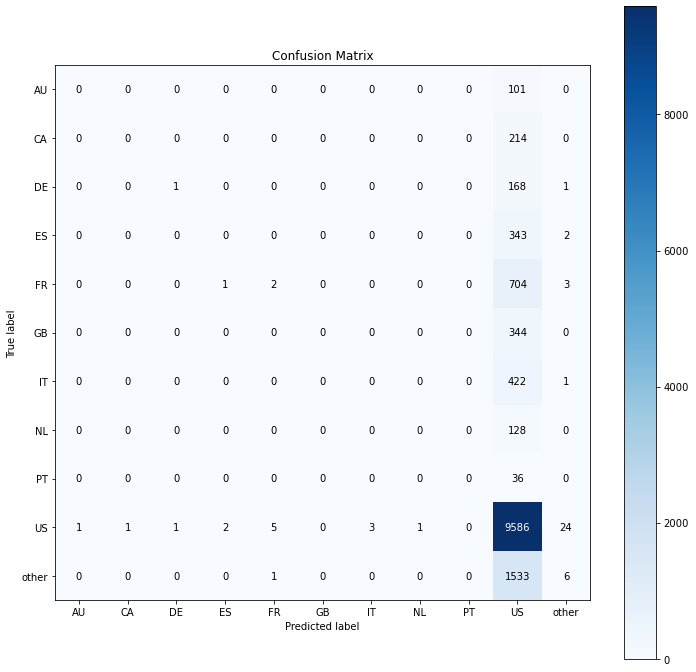

In [30]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn, zero_division=0))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

## **O Problema:** 
A acurácia não é uma métrica ideal para representar a performance do modelo.

### **Possíveis Causas:**

* Falta de Features Representativas do Fenômeno;
* Dados com Ruídos ("Sujeira")
* Escasses de exemplos de treino para outras classes (dados desbalanceados).
* Divergência entre o Viés dos Dados eo Viés do Modelo (è o modelo mais adequado?)

## Métricas:

### Accuracy:  
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todas as <font color='blue'>Predições</font> <font color='blue'>Realizadas</font>  pelo modelo.


$$Acurácia = \frac{Número de Predições Corretas}{Número de Predições Realizadas}$$

$$Acurácia = \frac{9528}{13635} = 69.87\%$$

### Precision:  
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todas as <font color='blue'>Predições</font> <font color='blue'>Realizadas</font>  pelo modelo em cada Classe.


$$Acurácia = \frac{Número de Predições Corretas Classe FR}{Número de Predições Classe FR}$$

$$Acurácia = \frac{3}{26} = 11.54\%$$

- Métrica útil quando uma das classes do problema possui certa prioridade.

### Recall (Sensitividade): 
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todos os <font color='blue'>Exemplos Reais</font> de cada Classe.

$$Recall = \frac{Número de Predições Corretas Classe FR}{Total de Exemplos da Classe FR}$$

$$Recall = \frac{3}{710} = 0.42\%$$

### F1-Score: 
- Média entre Precision e Recall.
    - Média Harmônica

$$F1-Score = 2*\frac{Precision * Recall}{precision + Recall}$$

$$F1-Score = 2*\frac{0.115 * 0.004}{0.115 * 0.004} = 0.008 $$

- Calcula-se F1-score para cada uma das classes, sendo ideal para problemas de classificação binários. Para problemas multiclasse não é recomendável a utilização dessa métrica, pois terá que ser calculada para cada uma das classes.

## Precisamos de <font color='red'>uma ÚNICA Métrica</font> que diga a <font color='blue'>Performance</font> do Modelo.

### Balanced Accuracy: 
-Média das Acurácias de Cada Classe

$$Balanced Accuracy = \frac{1}{NClasses} \sum_{i=1}^{NClasses} \frac{PredCorretasClass_i}{TotalPredClass_i} $$

$$Balanced Accuracy = 9\%$$


### Kappa Score: 
-Médir o Nível de Acordo entre 2 Avaliadores

$$KappaScore= \frac{\#NidelDeAcordo - (\#NivelDeAcordoAoAcaso)}{1- \#NivelDeAcordoAoAcaso}  $$

$$NivelDeAcordoAoAcaso = Prob_A * Prob_B$$



## 7.3. NN Performance - Cross- Validation

In [45]:
# generate k-fold
num_folds=5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_score_list = []

i=1
for train_ix, val_ix in kfold.split(X_train, y_train):
    
    print('Fold Number {}/{}'.format(i, num_folds))
    # get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]

    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # Categorically encode labels
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()

    # model definition
    model = ml.Sequential()
    model.add(Dense(256, input_dim=x_train_fold.shape[1], activation='relu'))
    model.add(Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=50, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)

    # invert prediction
    yhat_nn = np.ravel(ohe.inverse_transform(pred_nn))
    y_val_nn = np.ravel(y_val_fold)
    
    # metrics
    # Balanced Accuracy
    balanced_acc_list.append(m.balanced_accuracy_score(y_val_nn, yhat_nn))

    # Kappa Metrics
    kappa_score_list.append(m.cohen_kappa_score(y_val_nn, yhat_nn))

    i+=1

pd.DataFrame({'Model Name':	'MLP', 
    'Balanced ACC CV': [str(np.round(np.mean(balanced_acc_list),2)) + ' +/- ' + str(np.round(np.std(balanced_acc_list),2))],
    'KAPPA SCORE CV': [str(np.round(np.mean(kappa_score_list),2)) + ' +/- ' + str(np.round(np.std(kappa_score_list),2))]})


Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,Balanced ACC CV,KAPPA SCORE CV
0,MLP,0.09 +/- 0.0,0.0 +/- 0.0
